## Reinforcement Learning 4: *Monte Carlo Methods*

In [1]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display
from collections import namedtuple, defaultdict
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

 ### BlackJack

Following the examples in the lecture, let's use Monte Carlo methods to play BlackJack. Remember the task description
 from the lecture (see also course textbook, Example 5.1). We will use gym's pre-configured [`BlackJack` environment](https://www.gymlibrary.dev/environments/toy_text/blackjack/).

![](https://drive.google.com/uc?id=1R2-H6ra4BqFMJK752OAUNLaKia233V2o)

**Note:** In the exercises below, you are not given the complete implementations, but instead should try to solve the
exercises. The scaffold is in place and all you need to do is fill in the #TODO fields.
The solutions will be posted on Brightspace after the workgroups.

**Adapted from:**
- Byrne, D. (2020, September 22). [Learning To Win Blackjack With Monte Carlo Methods](https://towardsdatascience.com/learning-to-win-blackjack-with-monte-carlo-methods-61c90a52d53e). Medium.

Let's first prepare some visualizations for the task:

In [2]:
def plot_blackjack_values(V):
	def get_Z(x, y, usable_ace):
		if (x,y,usable_ace) in V:
			return V[x,y,usable_ace]
		else:
			return 0
	def get_figure(usable_ace, ax):
		x_range = np.arange(11, 22)
		y_range = np.arange(1, 11)
		X, Y = np.meshgrid(x_range, y_range)
		Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)
		surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
		ax.set_xlabel('Player\'s Current Sum')
		ax.set_ylabel('Dealer\'s Showing Card')
		ax.set_zlabel('State Value')
		ax.view_init(ax.elev, -120)

	fig = plt.figure(figsize=(20, 20))
	ax = fig.add_subplot(211, projection='3d')
	ax.set_title('Usable Ace')
	get_figure(True, ax)
	ax = fig.add_subplot(212, projection='3d')
	ax.set_title('No Usable Ace')
	get_figure(False, ax)
	plt.show()

def plot_policy(policy):
	def get_Z(x, y, usable_ace):
		if (x,y,usable_ace) in policy:
			return policy[x,y,usable_ace]
		else:
			return 1
	def get_figure(usable_ace, ax):
		x_range = np.arange(11, 22)
		y_range = np.arange(10, 0, -1)
		X, Y = np.meshgrid(x_range, y_range)
		Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
		surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
		plt.xticks(x_range)
		plt.yticks(y_range)
		plt.gca().invert_yaxis()
		ax.set_xlabel('Player\'s Current Sum')
		ax.set_ylabel('Dealer\'s Showing Card')
		ax.grid(color='w', linestyle='-', linewidth=1)
		divider = make_axes_locatable(ax)
		cax = divider.append_axes("right", size="5%", pad=0.1)
		cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
		cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
	fig = plt.figure(figsize=(15, 15))
	ax = fig.add_subplot(121)
	ax.set_title('Usable Ace')
	get_figure(True, ax)
	ax = fig.add_subplot(122)
	ax.set_title('No Usable Ace')
	get_figure(False, ax)
	plt.show()

**a**) Load and explore the `Blackjack-v1` environment:

In [3]:
env = gym.make('Blackjack-v1')

In [4]:
print("States: ", env.observation_space)
print("Actions: ", env.action_space)

States:  Tuple(Discrete(32), Discrete(11), Discrete(2))
Actions:  Discrete(2)


Note that each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, ..., 31\}$
- the dealer's face up card, $\in \{1, ..., 10\}$
- whether or not the player has a usable ace (no$=0$, yes$=1$).

The agent has two potential actions:
- STICK = 0
- HIT = 1

The return is only computed at the end of an episode:
- Loose = -1
- Tie = 0
- Win = 1

**b**) Run 10 episodes with a random policy.

In [9]:
def play_episode(env, display=True):
	episode = []
	rewards = []
	state, _ = env.reset()
	action_name = ["STICK", "HIT"]
	while True:
		# ToDo
		action = env.action_space.sample()
		next_state, reward, terminated, truncated, info = env.step(action)

		if display:
			print("Initial state:", state)
			print("Player: ",env.player)
			print("Dealer: ",env.dealer)
			print(action_name[action])
			print("Current state:", next_state)

		episode.append((state, action, reward))
		state = next_state
		if terminated:
			rewards.append(reward)
			if display:
				print("Player: ",env.player)
				print("Dealer: ",env.dealer)
				print("Reward:", reward)
			break
	return episode, rewards

In [17]:
n_episodes = 10
rw = []
for ep in range(n_episodes):
	ep, rwe = play_episode(env)
	rw.append(rwe[0])
print("Win: ",np.sum([t for t in rw if t > 0])/n_episodes*100,"%")
print("Tie: ",np.sum([t for t in rw if t == 0])/n_episodes*100,"%")
print("Lost: ",np.sum([t*-1 for t in rw if t < 0])/n_episodes*100,"%")

Initial state: (13, 10, 0)
Player:  [3, 10]
Dealer:  [10, 10]
STICK
Current state: (13, 10, 0)
Player:  [3, 10]
Dealer:  [10, 10]
Reward: -1.0
Initial state: (21, 9, 1)
Player:  [10, 1, 7]
Dealer:  [9, 10]
HIT
Current state: (18, 9, 0)
Initial state: (18, 9, 0)
Player:  [10, 1, 7, 5]
Dealer:  [9, 10]
HIT
Current state: (23, 9, 0)
Player:  [10, 1, 7, 5]
Dealer:  [9, 10]
Reward: -1.0
Initial state: (11, 2, 0)
Player:  [7, 4]
Dealer:  [2, 10, 8]
STICK
Current state: (11, 2, 0)
Player:  [7, 4]
Dealer:  [2, 10, 8]
Reward: -1.0
Initial state: (6, 8, 0)
Player:  [4, 2]
Dealer:  [8, 6, 4]
STICK
Current state: (6, 8, 0)
Player:  [4, 2]
Dealer:  [8, 6, 4]
Reward: -1.0
Initial state: (17, 8, 0)
Player:  [7, 10]
Dealer:  [8, 10]
STICK
Current state: (17, 8, 0)
Player:  [7, 10]
Dealer:  [8, 10]
Reward: -1.0
Initial state: (16, 10, 0)
Player:  [10, 6]
Dealer:  [10, 5, 5]
STICK
Current state: (16, 10, 0)
Player:  [10, 6]
Dealer:  [10, 5, 5]
Reward: -1.0
Initial state: (21, 6, 1)
Player:  [1, 10, 7]
D

**c**) **MC prediction**: Apply the *first-visit MC prediction* algorithms with *Exploring Starts (ES)* to estimate the
action-value function, $q_{\pi}(s, a)$ and calculate the value of an initial, random policy.

In [16]:
def update_Q(episode, Q, returns_sum, N, gamma=1.0):
	"""
	For each time step in the episode we carry out the first visit monte carlo method with exploring starts, checking if this is the first index of this state. Get the discounted reward and add it to the total reward for that state/action pair. Increment the times we have seen this state action pair and finally update the Q values
	"""
	for s, a, r in episode:
		first_occurence_idx = next(i for i, x in enumerate(episode) if x[0] == s)
		G = sum([x[2] * (gamma ** i) for i, x in enumerate(episode[first_occurence_idx:])])
		returns_sum[s][a] += G
		N[s][a] += 1.0
		Q[s][a] = returns_sum[s][a] / N[s][a]

In [32]:
gamma = 1.0
episode, rwe = play_episode(env, display=False)
for s, a, r  in episode:

	first_occurence_idx = next(i for i, x in enumerate(episode) if x[0] == s)
	print(first_occurence_idx)
	G = sum([x[2] * (gamma ** i) for i, x in enumerate(episode[first_occurence_idx:])])
	print(G)

0
-1.0


In [19]:
def mc_predict(env, num_episodes, gamma=1.0):
	"""
	This is the primary method. Plays through several episodes of the environment.
	"""
	returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
	N = defaultdict(lambda: np.zeros(env.action_space.n))
	Q = defaultdict(lambda: np.zeros(env.action_space.n))

	for i_episode in tqdm(range(1, num_episodes+1)):
		episode, _ = play_episode(env, display=False)
		update_Q(episode, Q, returns_sum, N)
	return Q

100%|██████████| 100000/100000 [00:07<00:00, 12889.91it/s]


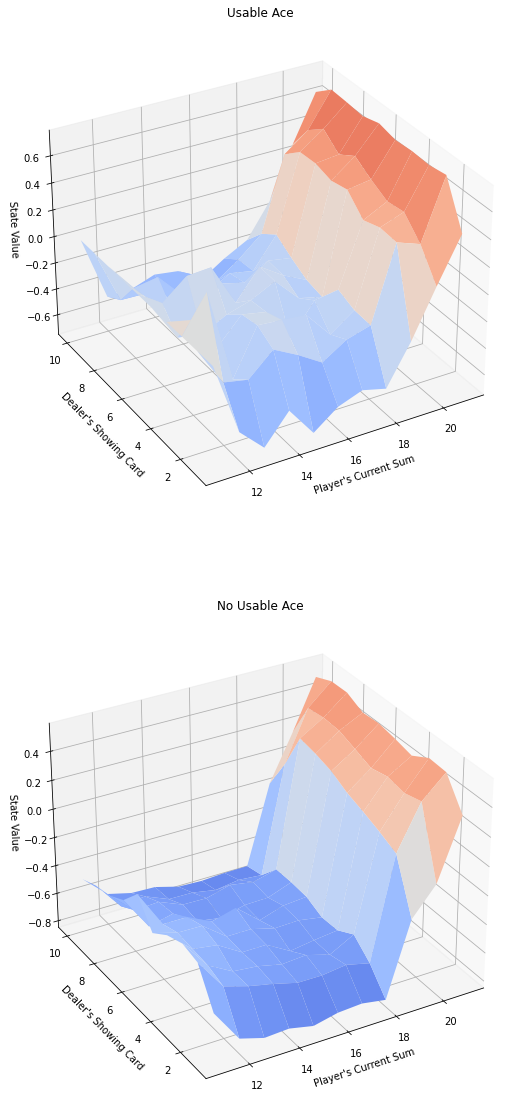

In [20]:
# predict the policy values for our test policy, over a large number of episodes
sample_episodes = 100000
Q = mc_predict(env, sample_episodes)

# get the state value function for our test policy
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v)))
                 for k, v in Q.items())

# plot the state value functions
plot_blackjack_values(V_to_plot)

**d**) **MC control**: Using the methods above to compute the action-value function, $q_{\pi}(s, a)$ and use these
values to optimize the policy. Use on-policy MC control with $\epsilon$-greedy action selection.

In [33]:
def get_probs(Q_s, epsilon, nA):
	"""
	Get the probability of taking the best known action according to epsilon (epsilon-greedy).
	Returns the policy for the Q value given
	"""
	policy_s = np.ones(nA) * epsilon / nA
	best_a = np.argmax(Q_s)
	# TODO: epsilon-greedy action selection
	policy_s[best_a] = 1-epsilon+epsilon/nA
	return policy_s

In [34]:
def best_policy(Q, nA):
	"""
	returns the best actions for each Q value in the policy
	"""
	return dict((k,np.argmax(v)) for k, v in Q.items())

In [35]:
def update_Q(env, episode, Q, alpha, gamma):
	"""
	Calculate the new Q values for the actions taken in the given episode.
	Returns the new Q policy
	"""
	for s, a, r in episode:
		first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == s)
		G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[first_occurence_idx:])])
		Q[s][a] = Q[s][a] + alpha*(G - Q[s][a])

	return Q

In [36]:
def play_game(env, Q, epsilon, nA):
	"""
	generates an episode from following the epsilon-greedy policy containing the state, action and reward for
	each time step in the episode.
	Returns all step information for that episode
	"""
	episode = []
	state, _ = env.reset()
	while True:
		probs = get_probs(Q[state], epsilon, nA)
		action = np.random.choice(np.arange(nA), p=probs) if state in Q else env.action_space.sample()
		next_state, reward, terminated, truncated, info = env.step(action)
		episode.append((state, action, reward))
		state = next_state
		if terminated:
			break
	return episode

In [37]:
def mc_control(env, num_episodes):
	"""
	main method. Iterates through episodes updating epsilon after each, retrieves the list of states, actions
	and rewards from the last episode and use them to calculate the updated Q values
	"""
	epsilon = 1.0
	eps_min = 0.01
	decay = 0.9999
	alpha = 0.001
	gamma = 1.0

	nA = env.action_space.n
	Q = defaultdict(lambda: np.zeros(nA))
	for i_episode in tqdm(range(1, num_episodes+1)):
		epislon = max(epsilon*decay, eps_min)
		episode = play_game(env, Q, epsilon, nA)
		Q = update_Q(env, episode, Q, alpha, gamma)

	policy = best_policy(Q, nA)
	return policy, Q

100%|██████████| 100000/100000 [00:16<00:00, 6052.64it/s]


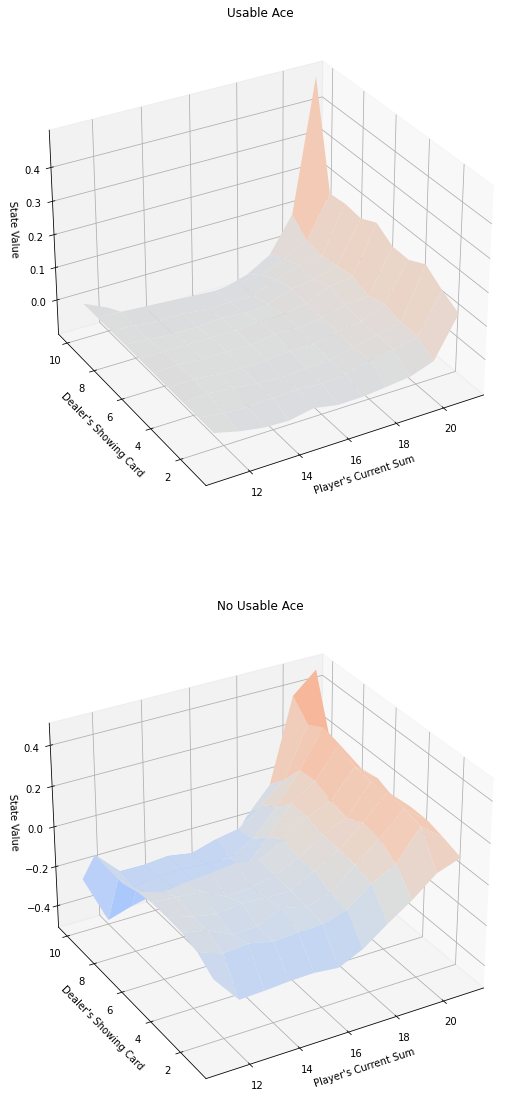

In [38]:
n_episodes = 100000
policy, Q = mc_control(env, n_episodes)
V = dict((k,np.max(v)) for k, v in Q.items())

plot_blackjack_values(V)

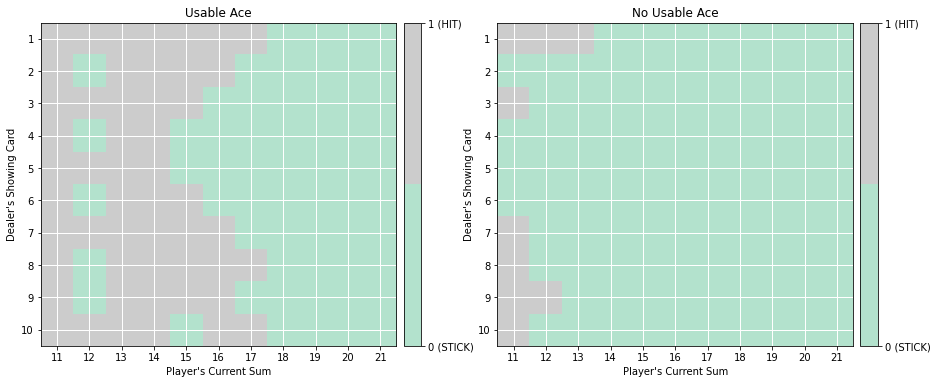

In [39]:
plot_policy(policy)

**e**) **Sample efficiency**. MC methods require hundreds of thousands of sample episodes to converge. Study how the number of samples affects the learned value functions and policies.

100%|██████████| 10000/10000 [00:02<00:00, 4684.32it/s]


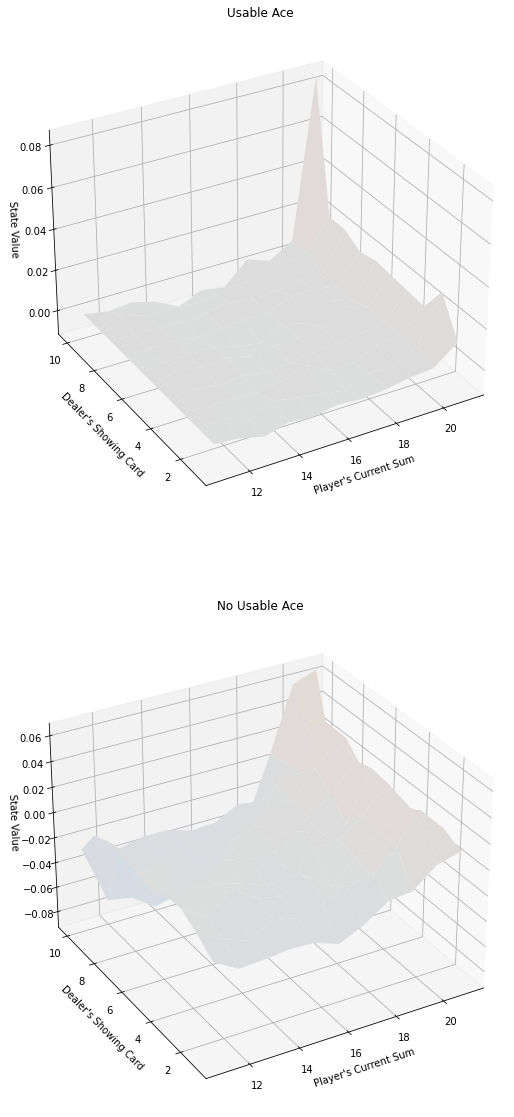

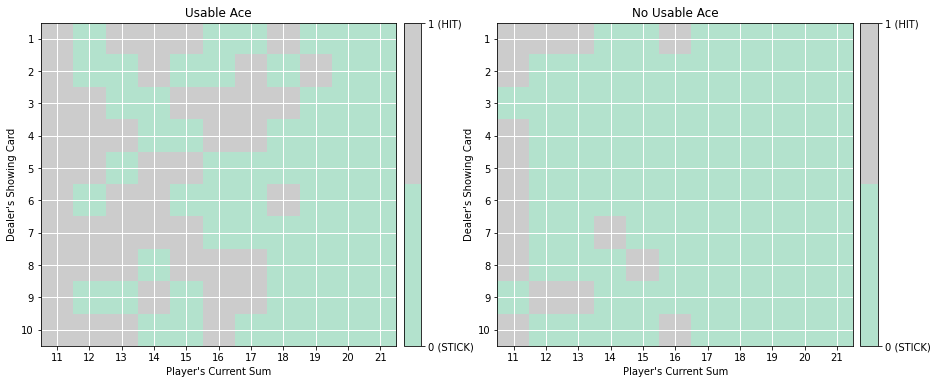

In [40]:
policy, Q = mc_control(env, 10000)
V = dict((k,np.max(v)) for k, v in Q.items())
plot_blackjack_values(V)
plot_policy(policy)

100%|██████████| 100000/100000 [00:16<00:00, 6129.30it/s]


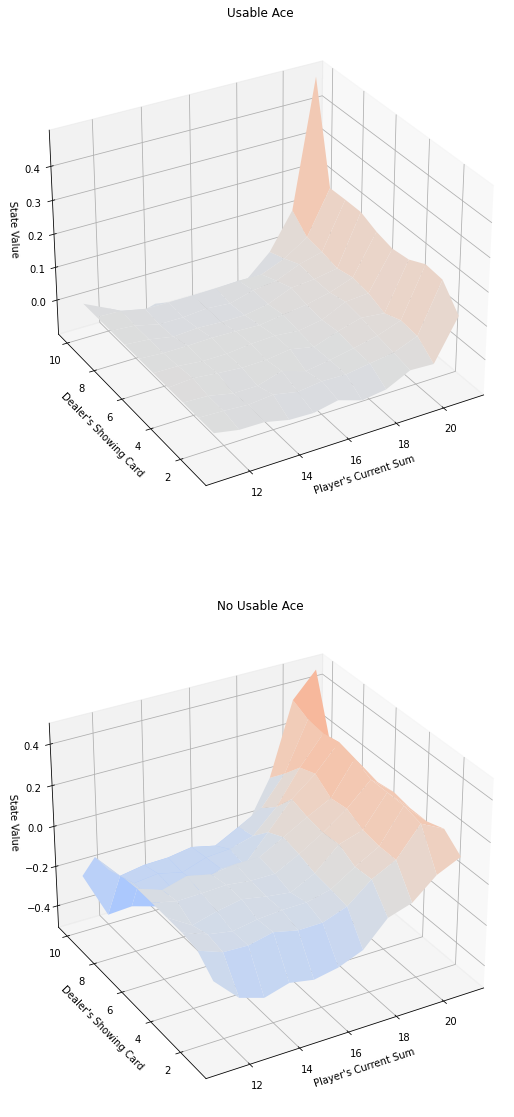

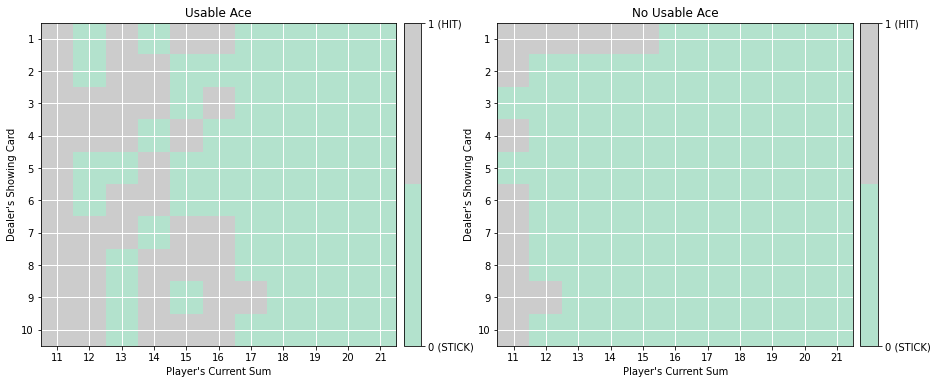

In [41]:
policy, Q = mc_control(env, 100000)
V = dict((k,np.max(v)) for k, v in Q.items())
plot_blackjack_values(V)
plot_policy(policy)

100%|██████████| 1000000/1000000 [02:09<00:00, 7738.29it/s]


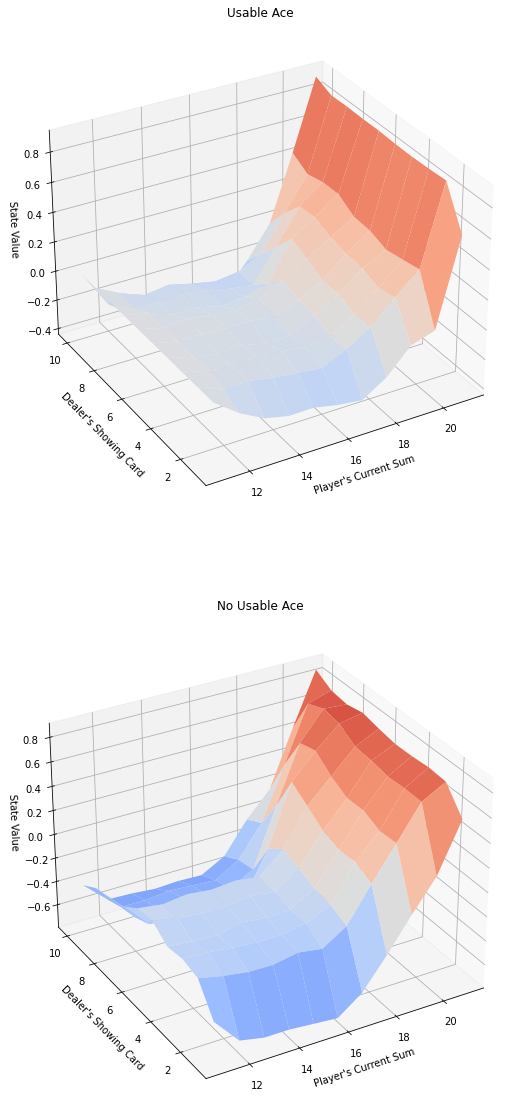

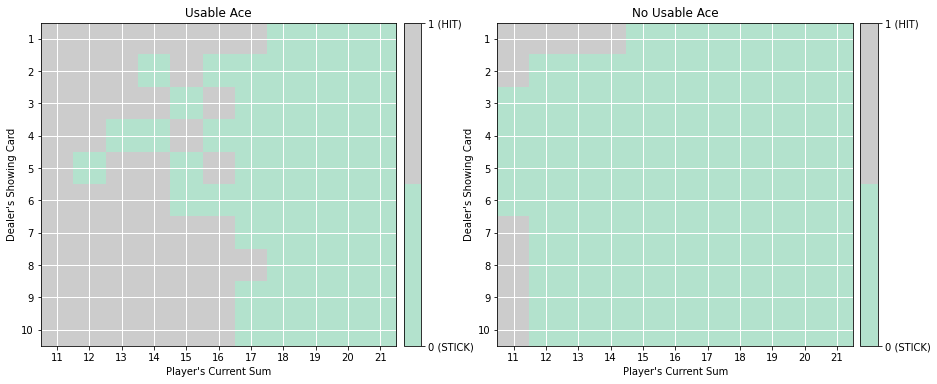

In [42]:
policy, Q = mc_control(env, 1000000)
V = dict((k,np.max(v)) for k, v in Q.items())
plot_blackjack_values(V)
plot_policy(policy)